## We will first train a ColBERT sentence embedding.

In [1]:
# Machine details
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5754991433281369222
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15703311680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9166332265916692221
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


## Import model

In [2]:
model = keras.models.load_model("colbert-trained/")
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 20)]         0                                            
_______________________________________________________________________________________

In [3]:
# Dependencies
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# import tensorflow_hub as hub
import tensorflow as tf
# import bert_tokenization as tokenization
import tensorflow.keras.backend as K
# from tensorflow import keras

import os
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

import seaborn as sns
import string
import re    #for regex

np.set_printoptions(suppress=True)
print(tf.__version__)

2.4.1


In [4]:
# Parameters for data
training_sample_count = 1000 # 4000
test_count = 1000

MAX_SENTENCE_LENGTH = 20
MAX_SENTENCES = 5
MAX_LENGTH = 100

## Read sample testing data

In [5]:
!ls
# os.chdir("joke-gen/ColBERT humor")

Data		 colbert-trained.zip  modelConf.json
colbert-trained  mega.sh	      train-colbert-evaluate-seqgan.ipynb


In [6]:
df = pd.read_csv('Data/dataset.csv')

df_train = pd.read_csv('Data/train.csv')
display(df_train.head(3))
df_train = df_train[:training_sample_count]

df_test = pd.read_csv('Data/dev.csv')
display(df_test.head(3))
df_test = df_test[:test_count]

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True


,text,humor
0,What kind of cat should you take into the des...,True
1,Remember when people used to have to be in sha...,True
2,Pizza is always good. - everyone we'll see abo...,True


In [7]:
test_df_y = df_test.copy()
del df_test['humor']

df_sub = test_df_y.copy()

print(len(df),len(df_train),len(df_test))
display(df_train.head())
display(df_test.head())

200000 1000 1000


,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


,text
0,What kind of cat should you take into the des...
1,Remember when people used to have to be in sha...
2,Pizza is always good. - everyone we'll see abo...
3,"What's 6 inches long hard, bent, and in my pan..."
4,Black teen's response to violence in his commu...


In [8]:
output_categories = list(df_train.columns[[1]])
input_categories = list(df_train.columns[[0]])

TARGET_COUNT = len(output_categories)

print('\ninput categories:\n\t', input_categories)
print('\noutput TARGET_COUNT:\n\t', TARGET_COUNT)
print('\noutput categories:\n\t', output_categories)


input categories:
	 ['text']

output TARGET_COUNT:
	 1

output categories:
	 ['humor']


## Preprocess the data

In [9]:
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig

MODEL_TYPE = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)

In [10]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
def return_id(str1, str2, truncation_strategy, length):

    inputs = tokenizer.encode_plus(str1, str2,
        add_special_tokens=True,
        max_length=length,
        truncation_strategy=truncation_strategy)

    input_ids =  inputs["input_ids"]
    input_masks = [1] * len(input_ids)
    input_segments = inputs["token_type_ids"]
    padding_length = length - len(input_ids)
    padding_id = tokenizer.pad_token_id
    input_ids = input_ids + ([padding_id] * padding_length)
    input_masks = input_masks + ([0] * padding_length)
    input_segments = input_segments + ([0] * padding_length)

    return [input_ids, input_masks, input_segments]


def compute_input_arrays(df, columns, tokenizer):
    model_input = []
    for xx in range((MAX_SENTENCES*3)+3):
        model_input.append([])
    
    for _, row in tqdm(df[columns].iterrows()):
        i = 0
        
        # sent
        sentences = sent_tokenize(row.text)
        for xx in range(MAX_SENTENCES):
            s = sentences[xx] if xx<len(sentences) else ''
            ids_q, masks_q, segments_q = return_id(s, None, 'longest_first', MAX_SENTENCE_LENGTH)
            model_input[i].append(ids_q)
            i+=1
            model_input[i].append(masks_q)
            i+=1
            model_input[i].append(segments_q)
            i+=1
        
        # full row
        ids_q, masks_q, segments_q = return_id(row.text, None, 'longest_first', MAX_LENGTH)
        model_input[i].append(ids_q)
        i+=1
        model_input[i].append(masks_q)
        i+=1
        model_input[i].append(segments_q)
        
    for xx in range((MAX_SENTENCES*3)+3):
        model_input[xx] = np.asarray(model_input[xx], dtype=np.int32)
        
    print(model_input[0].shape)
    return model_input

In [12]:
inputs      = compute_input_arrays(df_train, input_categories, tokenizer)
test_inputs = compute_input_arrays(df_test, input_categories, tokenizer)

0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(1000, 20)


0it [00:00, ?it/s]

(1000, 20)


In [24]:
print(len(inputs), len(inputs[0]), len(inputs[0][0]))

# See the output of embedding
xx = 12
print(df_train.iloc[xx,0])
print(sent_tokenize(df_train.iloc[xx,0]))
inputs[0][xx], inputs[3][xx], inputs[6][xx], inputs[15][xx]

18 1000 20
Want to know why athletes chose to #takeaknee? look at our broken justice system
['Want to know why athletes chose to #takeaknee?', 'look at our broken justice system']


(array([  101,  2215,  2000,  2113,  2339,  7576,  4900,  2000,  1001,
         2202,  4817, 24045,  1029,   102,     0,     0,     0,     0,
            0,     0], dtype=int32),
 array([ 101, 2298, 2012, 2256, 3714, 3425, 2291,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([101, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0], dtype=int32),
 array([  101,  2215,  2000,  2113,  2339,  7576,  4900,  2000,  1001,
         2202,  4817, 24045,  1029,  2298,  2012,  2256,  3714,  3425,
         2291,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,

In [14]:
def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

outputs = compute_output_arrays(df_train, output_categories)
outputs[:3]

array([[False],
       [False],
       [ True]])

Since it's a regression with outcome between 0 and 1, it's reasonable to use binary_crossentropy optimizer and MAE loss function

## Evaluation

In [96]:
# Evaluation Metrics
import sklearn
def print_evaluation_metrics(y_true, y_pred, label='', is_regression=True, label2=''):
    print('==================', label2)
    ### For regression
    if is_regression:
        print('mean_absolute_error',label,':', sklearn.metrics.mean_absolute_error(y_true, y_pred))
        print('mean_squared_error',label,':', sklearn.metrics.mean_squared_error(y_true, y_pred))
        print('r2 score',label,':', sklearn.metrics.r2_score(y_true, y_pred))
        #     print('max_error',label,':', sklearn.metrics.max_error(y_true, y_pred))
        return sklearn.metrics.mean_squared_error(y_true, y_pred)
    else:
        ### FOR Classification
#         print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#         print('average_precision_score',label,':', sklearn.metrics.average_precision_score(y_true, y_pred))
#         print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#         print('accuracy_score',label,':', sklearn.metrics.accuracy_score(y_true, y_pred))
        print('f1_score',label,':', sklearn.metrics.f1_score(y_true, y_pred))
        
        matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
        print(matrix)
        TP,TN,FP,FN = matrix[1][1],matrix[0][0],matrix[0][1],matrix[1][0]
        Accuracy = (TP+TN)/(TP+FP+FN+TN)
        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)
        F1 = 2*(Recall * Precision) / (Recall + Precision)
        print('Acc', Accuracy, 'Prec', Precision, 'Rec', Recall, 'F1',F1)
#         return sklearn.metrics.accuracy_score(y_true, y_pred)
        return {'Acc': Accuracy, 'Prec': Precision, 'Rec': Recall, 'F1': F1}

In [16]:
preds = model.predict(inputs)
print_evaluation_metrics(np.array(outputs), np.array(preds), '')

mean_absolute_error  : 0.008370923
mean_squared_error  : 0.0059296396
r2 score  : 0.9762767920443749


0.0059296396

## Predict on test sets and produce binary submission

In [17]:
test_preds = model.predict(test_inputs)

In [19]:
df_sub['pred_bi'] = (test_preds > 0.5)

print_evaluation_metrics(df_sub['humor'], df_sub['pred_bi'], '', False, 'SPLIT on '+str(split))

df_sub.to_csv('sub.csv', index=False)
df_sub.head()

================== SPLIT on 0.9
f1_score  : 0.9835111542192047
[[476   8]
 [  9 507]]
Acc 0.983 Prec 0.9844660194174757 Rec 0.9825581395348837 F1 0.9835111542192047


,text,humor,pred_bi
0,What kind of cat should you take into the des...,True,True
1,Remember when people used to have to be in sha...,True,True
2,Pizza is always good. - everyone we'll see abo...,True,True
3,"What's 6 inches long hard, bent, and in my pan...",True,True
4,Black teen's response to violence in his commu...,False,False


In [20]:
print('Texts that the model correctly predicts:')
df_sub[df_sub['pred_bi']==df_sub['humor']]

Texts that the model correctly predicts:


,text,humor,pred_bi
0,What kind of cat should you take into the des...,True,True
1,Remember when people used to have to be in sha...,True,True
2,Pizza is always good. - everyone we'll see abo...,True,True
3,"What's 6 inches long hard, bent, and in my pan...",True,True
4,Black teen's response to violence in his commu...,False,False
...,...,...,...
995,Watch: dude with rod in his head seems pretty ...,False,False
996,Why are giraffes slow to apologize? it takes t...,True,True
997,I think some drugs should be legalized... but ...,True,True
998,What did miss muffet and saddam hussein have i...,True,True


In [21]:
print('Texts that the model failed to correctly predict:')
df_sub[df_sub['pred_bi']!=df_sub['humor']]

Texts that the model failed to correctly predict:


,text,humor,pred_bi
252,Ariana grande looks like she was designed in a...,True,False
303,"If you're happy and you know it, share your meds",True,False
309,Friends don't let friends make harlem shake' v...,True,False
310,The whip was especially popular in the 1800's,True,False
345,One out of five dentists has the courage to sp...,True,False
361,New subway slogan idea from jared 12 is the ne...,True,False
372,The easiest way to water plants is...using a t...,False,True
383,What is this 'wrong hole' you people speak of?,True,False
525,What happens when you retweet a compliment abo...,True,False
572,The boomerang is australia's chief export (and...,True,False


## Process and evaluate SeqGAN jokes

In [98]:
metrics = []

### SeqGAN without Rollout

In [99]:
path = "../SeqGAN/output/"
filename = "jokes_10k.txt"
fp1 = open(path+filename,"r")
sentence = []

for l in fp1.readlines():
#     print(l.replace("<pad> ",""))
    sentence.append(l.replace("<pad> ","").replace("\n",""))
fp1.close()
df = pd.DataFrame(sentence,columns =['text'])

In [100]:
print(len(df))
df['humor'] = True
df_sub = df.copy()
df.head()

10001


,text,humor
0,unbowed unbent unbroken . told his friends wer...,True
1,i m against ? joe with being sure to bend the ...,True
2,. what is a blonde out of the government ? for...,True
3,how long do you tell if you t laugh ? an extro...,True
4,,True


In [101]:
output_eval_inputs = compute_input_arrays(df, ['text'], tokenizer)

0it [00:00, ?it/s]

(10001, 20)


In [102]:
output_eval_preds = model.predict(output_eval_inputs)

In [103]:
df_sub['pred_bi'] = (output_eval_preds > 0.5)

metrics.append(print_evaluation_metrics(df_sub['humor'], df_sub['pred_bi'], '', False, 'SPLIT on '+str(0.5)))

# df_sub.to_csv('sub.csv', index=False)
df_sub.head()

================== SPLIT on 0.5
f1_score  : 0.9631971801783122
[[   0    0]
 [ 710 9291]]
Acc 0.929007099290071 Prec 1.0 Rec 0.929007099290071 F1 0.9631971801783122


,text,humor,pred_bi
0,unbowed unbent unbroken . told his friends wer...,True,True
1,i m against ? joe with being sure to bend the ...,True,True
2,. what is a blonde out of the government ? for...,True,True
3,how long do you tell if you t laugh ? an extro...,True,True
4,,True,False


In [104]:
print('Texts that the model find not funny:')
df_sub[(df_sub['pred_bi']!=df_sub['humor'])&(df_sub['text']!='')]

Texts that the model find not funny:


,text,humor,pred_bi
46,knock,True,False
64,obama didn t don t force .,True,False
66,like a recent electricity act,True,False
157,stair,True,False
196,this dad is too big,True,False
...,...,...,...
9908,jkfsh,True,False
9916,meta c art s family is controversy ? . .,True,False
9939,knock,True,False
9952,the quick fit just heard and this tour and not...,True,False


### SeqGAN with Rollout

In [105]:
path = "../SeqGAN-rollout/output/"
filename = "jokes_rollout.txt"
fp1 = open(path+filename,"r")
sentence = []

for l in fp1.readlines():
#     print(l.replace("<pad> ",""))
    sentence.append(l.replace("<pad> ","").replace("\n",""))
fp1.close()
df = pd.DataFrame(sentence,columns =['text'])

In [106]:
print(len(df))
df['humor'] = True
df_sub = df.copy()
df.head()

10001


,text,humor
0,dylsexic man .,True
1,kerbal takei,True
2,luz .,True
3,submit an old lady,True
4,rectified .,True


In [107]:
output_eval_inputs = compute_input_arrays(df, ['text'], tokenizer)
output_eval_preds = model.predict(output_eval_inputs)

0it [00:00, ?it/s]

(10001, 20)


In [108]:
df_sub['pred_bi'] = (output_eval_preds > 0.5)

metrics.append(print_evaluation_metrics(df_sub['humor'], df_sub['pred_bi'], '', False, 'SPLIT on '+str(0.5)))

# df_sub.to_csv('sub.csv', index=False)
df_sub.head()

================== SPLIT on 0.5
f1_score  : 0.8183375672003308
[[   0    0]
 [3075 6926]]
Acc 0.6925307469253075 Prec 1.0 Rec 0.6925307469253075 F1 0.8183375672003308


,text,humor,pred_bi
0,dylsexic man .,True,True
1,kerbal takei,True,False
2,luz .,True,True
3,submit an old lady,True,False
4,rectified .,True,True


In [109]:
print('Texts that the model find not funny:')
df_sub[(df_sub['pred_bi']!=df_sub['humor'])&(df_sub['text']!='')]

Texts that the model find not funny:


,text,humor,pred_bi
1,kerbal takei,True,False
3,submit an old lady,True,False
5,criticise a school .,True,False
10,kerbal mart,True,False
15,visiting a roof,True,False
...,...,...,...
9990,okcupid himself,True,False
9991,kerbal mourinho,True,False
9992,i met a cuban,True,False
9995,kerbal nominee burger king,True,False


## SeqGAN with different training steps (g steps, d steps, k)

### SeqGAN G1D1K10

In [110]:
path = "../SeqGAN/d1k10/"
filename = "sentences_d1_k10.txt"
fp1 = open(path+filename,"r")
sentence = []

for l in fp1.readlines():
#     print(l.replace("<pad> ",""))
    sentence.append(l.replace("<pad> ","").replace("\n",""))
fp1.close()
df = pd.DataFrame(sentence,columns =['text'])

In [111]:
print(len(df))
df['humor'] = True
df_sub = df.copy()
df.head()

10001


,text,humor
0,why are the black man was never helps ? and th...,True
1,why do librarian the little people go in his w...,True
2,3 . have trump follow of mars away . content i...,True
3,mental illness everyone mean you re used to see,True
4,why do turkey give a point stickers it like a ...,True


In [112]:
output_eval_inputs = compute_input_arrays(df, ['text'], tokenizer)
output_eval_preds = model.predict(output_eval_inputs)

0it [00:00, ?it/s]

(10001, 20)


In [113]:
df_sub['pred_bi'] = (output_eval_preds > 0.5)

metrics.append(print_evaluation_metrics(df_sub['humor'], df_sub['pred_bi'], '', False, 'SPLIT on '+str(0.5)))

# df_sub.to_csv('sub.csv', index=False)
df_sub.head()

================== SPLIT on 0.5
f1_score  : 0.9823454591706945
[[   0    0]
 [ 347 9654]]
Acc 0.9653034696530347 Prec 1.0 Rec 0.9653034696530347 F1 0.9823454591706945


,text,humor,pred_bi
0,why are the black man was never helps ? and th...,True,True
1,why do librarian the little people go in his w...,True,True
2,3 . have trump follow of mars away . content i...,True,True
3,mental illness everyone mean you re used to see,True,True
4,why do turkey give a point stickers it like a ...,True,True


In [114]:
print('Texts that the model find not funny:')
df_sub[(df_sub['pred_bi']!=df_sub['humor'])&(df_sub['text']!='')]

Texts that the model find not funny:


,text,humor,pred_bi
34,what country long,True,False
94,nietzsche,True,False
103,deaf,True,False
127,if you bolt . and won,True,False
149,and someone jones,True,False
...,...,...,...
9893,new divorced 1945,True,False
9903,did these people get the math office,True,False
9952,working a bit has kim removed,True,False
9963,stop all the frog live for spinach,True,False


### SeqGAN with G1D5K3

In [115]:
path = "../SeqGAN/d5k3/"
filename = "sentences_d5_k3.txt"
fp1 = open(path+filename,"r")
sentence = []

for l in fp1.readlines():
#     print(l.replace("<pad> ",""))
    sentence.append(l.replace("<pad> ","").replace("\n",""))
fp1.close()
df = pd.DataFrame(sentence,columns =['text'])

In [116]:
print(len(df))
df['humor'] = True
df_sub = df.copy()
df.head()

10001


,text,humor
0,there just it is so got a queen . . in my year...,True
1,the life was acquitted of a pizza . . . . it d...,True
2,what do ego who do lying ? . balls in a tight,True
3,what kind of pants repair joe pussies ? . the ...,True
4,underwear are my best terrible face with a rab...,True


In [117]:
output_eval_inputs = compute_input_arrays(df, ['text'], tokenizer)
output_eval_preds = model.predict(output_eval_inputs)

0it [00:00, ?it/s]

(10001, 20)


In [118]:
df_sub['pred_bi'] = (output_eval_preds > 0.5)

metrics.append(print_evaluation_metrics(df_sub['humor'], df_sub['pred_bi'], '', False, 'SPLIT on '+str(0.5)))

# df_sub.to_csv('sub.csv', index=False)
df_sub.head()

================== SPLIT on 0.5
f1_score  : 0.9840511986997155
[[   0    0]
 [ 314 9687]]
Acc 0.9686031396860314 Prec 1.0 Rec 0.9686031396860314 F1 0.9840511986997155


,text,humor,pred_bi
0,there just it is so got a queen . . in my year...,True,True
1,the life was acquitted of a pizza . . . . it d...,True,True
2,what do ego who do lying ? . balls in a tight,True,True
3,what kind of pants repair joe pussies ? . the ...,True,True
4,underwear are my best terrible face with a rab...,True,True


In [119]:
print('Texts that the model find not funny:')
df_sub[(df_sub['pred_bi']!=df_sub['humor'])&(df_sub['text']!='')]

Texts that the model find not funny:


,text,humor,pred_bi
76,paul walker link the u . . . . the,True,False
77,jihadists to meowth,True,False
87,why the investment burger exceptions,True,False
122,irish based knock,True,False
130,conversation,True,False
...,...,...,...
9901,bernie masonry,True,False
9924,how the man does a wiener dumpling,True,False
9926,about,True,False
9949,chinese girl bae for new best lego planets meter,True,False


### SeqGAN G100D3K450 [mode collapse]

In [120]:
path = "../SeqGAN/g100d1k10/"
filename = "sentences_d3_k4.txt"
fp1 = open(path+filename,"r")
sentence = []

for l in fp1.readlines():
#     print(l.replace("<pad> ",""))
    sentence.append(l.replace("<pad> ","").replace("\n",""))
fp1.close()
df = pd.DataFrame(sentence,columns =['text'])

In [121]:
# Generated the same sentence due to mode collapse
print(len(df))
df['humor'] = True
df_sub = df.copy()
df.head()

10001


,text,humor
0,request god spic spirits me . liabilitirary sp...,True
1,request god spic spirits me . liabilitirary sp...,True
2,request god spic spirits me me . liabilitirary...,True
3,request god spic spirits me . liabilitirary sp...,True
4,request god spic spirits me . liabilitirary sp...,True


In [122]:
output_eval_inputs = compute_input_arrays(df, ['text'], tokenizer)
output_eval_preds = model.predict(output_eval_inputs)

0it [00:00, ?it/s]

(10001, 20)


In [123]:
df_sub['pred_bi'] = (output_eval_preds > 0.5)

metrics.append(print_evaluation_metrics(df_sub['humor'], df_sub['pred_bi'], '', False, 'SPLIT on '+str(0.5)))

# df_sub.to_csv('sub.csv', index=False)
df_sub.head()

================== SPLIT on 0.5
f1_score  : 0.999950002499875
[[    0     0]
 [    1 10000]]
Acc 0.9999000099990001 Prec 1.0 Rec 0.9999000099990001 F1 0.999950002499875


,text,humor,pred_bi
0,request god spic spirits me . liabilitirary sp...,True,True
1,request god spic spirits me . liabilitirary sp...,True,True
2,request god spic spirits me me . liabilitirary...,True,True
3,request god spic spirits me . liabilitirary sp...,True,True
4,request god spic spirits me . liabilitirary sp...,True,True


In [124]:
print("All texts:")
set(df_sub['text'])

All texts:


{'',
 'request . liabilitirary spit swap flying flying flying flying flying flying flying flying flying flying flying flying flying flying flying ',
 'request and has flying flying bar pear against flying flying flying flying flying flying flying flying flying flying flying flying ',
 'request and spic spirits me advertising . liabilitirary spit swap flying flying flying flying flying flying flying flying flying flying ',
 'request because archeologists and bar tired bern on mexican mexican archeologists bar . mexican archeologists bar . archeologists bar . ',
 'request because archeologists bar because archeologists bar because bar tired bar bar bar tired mexican archeologists bar . archeologists bar ',
 'request can archeologists . flying flying flying flying flying flying flying flying flying flying flying flying flying flying flying flying ',
 'request can harmless spray can . liabilitirary spit swap flying flying flying flying flying flying flying flying flying flying flying ',
 '

### A quick recap of results

In [128]:
print("SeqGAN w/o Rollout", metrics[0])
print("SeqGAN w/ Rollout", metrics[1])
print("SeqGAN D1K10", metrics[2])
print("SeqGAN D5K3", metrics[3])
print("SeqGAN G100D3K450", metrics[4])

SeqGAN w/o Rollout {'Acc': 0.929007099290071, 'Prec': 1.0, 'Rec': 0.929007099290071, 'F1': 0.9631971801783122}
SeqGAN w/ Rollout {'Acc': 0.6925307469253075, 'Prec': 1.0, 'Rec': 0.6925307469253075, 'F1': 0.8183375672003308}
SeqGAN D1K10 {'Acc': 0.9653034696530347, 'Prec': 1.0, 'Rec': 0.9653034696530347, 'F1': 0.9823454591706945}
SeqGAN D5K3 {'Acc': 0.9686031396860314, 'Prec': 1.0, 'Rec': 0.9686031396860314, 'F1': 0.9840511986997155}
SeqGAN G100D3K450 {'Acc': 0.9999000099990001, 'Prec': 1.0, 'Rec': 0.9999000099990001, 'F1': 0.999950002499875}


## BLEU score

In [1]:
from fast_bleu import BLEU, SelfBLEU
import pandas as pd
bleu_scores = []

#### BLEU score for SeqGAN w/o Rollout

In [2]:
fp1 = open("../SeqGAN/jokes.csv","r")
ref = []
for l in fp1.readlines():
    i = l.index(",")
#     print(l[i+1:])
    ref.append(l[i+1:-1].split())
fp1.close()
ref = ref[1:]

In [3]:
path = "../SeqGAN/output/"
filename = "jokes_10k.txt"
fp1 = open(path+filename,"r")
sentence = []

for l in fp1.readlines():
#     print(l.replace("<pad> ",""))
    sentence.append([l.replace("<pad> ","").replace("\n","").split()])
fp1.close()
df = pd.DataFrame(sentence,columns =['text'])
hypotheses = df['text'].tolist()
# hypotheses = [hyp1]

In [4]:
weights = {'trigram': (1/3., 1/3., 1/3.)}
bleu = BLEU(ref, weights)
self_bleu = SelfBLEU(hypotheses, weights)
trigram = bleu.get_score(hypotheses)['trigram']
self_trigram = self_bleu.get_score()['trigram']
bleu_avg = sum(trigram)/len(trigram)
self_avg = sum(self_trigram)/len(self_trigram)
print("The trigram BLEU score average is: ", bleu_avg)
print("Its SelfBLEU score average is: ", self_avg)

The trigram BLEU score average is:  0.48825516778786526
Its SelfBLEU score average is:  0.49914322678525486


In [5]:
bleu_scores.append((bleu_avg, self_avg))

In [6]:
del bleu, self_bleu

#### BLEU score for SeqGAN w/ Rollout

In [7]:
fp1 = open("../SeqGAN/jokes.csv","r")
ref = []
for l in fp1.readlines():
    i = l.index(",")
#     print(l[i+1:])
    ref.append(l[i+1:-1].split())
fp1.close()
ref = ref[1:]

In [8]:
path = "../SeqGAN-rollout/output/"
filename = "jokes_rollout.txt"
fp1 = open(path+filename,"r")
sentence = []

for l in fp1.readlines():
#     print(l.replace("<pad> ",""))
    sentence.append([l.replace("<pad> ","").replace("\n","").split()])
fp1.close()
df = pd.DataFrame(sentence,columns =['text'])
hypotheses = df['text'].tolist()

In [9]:
weights = {'trigram': (1/3., 1/3., 1/3.)}
bleu = BLEU(ref, weights)
self_bleu = SelfBLEU(hypotheses, weights)
trigram = bleu.get_score(hypotheses)['trigram']
self_trigram = self_bleu.get_score()['trigram']
bleu_avg = sum(trigram)/len(trigram)
self_avg = sum(self_trigram)/len(self_trigram)
print("The trigram BLEU score average is: ", bleu_avg)
print("Its SelfBLEU score average is: ", self_avg)

The trigram BLEU score average is:  0.33816560359254516
Its SelfBLEU score average is:  0.413591621531638


In [10]:
bleu_scores.append((bleu_avg, self_avg))

In [11]:
del bleu, self_bleu

#### BLEU score for SeqGAN G1D1K10

In [12]:
path = "../SeqGAN/g1d1k10/"
filename = "sentences_g1d1k10.txt"
fp1 = open(path+filename,"r")
sentence = []

for l in fp1.readlines():
#     print(l.replace("<pad> ",""))
    sentence.append([l.replace("<pad> ","").replace("\n","").split()])
fp1.close()
df = pd.DataFrame(sentence,columns =['text'])
hypotheses = df['text'].tolist()

In [13]:
weights = {'trigram': (1/3., 1/3., 1/3.)}
bleu = BLEU(ref, weights)
self_bleu = SelfBLEU(hypotheses, weights)
trigram = bleu.get_score(hypotheses)['trigram']
self_trigram = self_bleu.get_score()['trigram']
bleu_avg = sum(trigram)/len(trigram)
self_avg = sum(self_trigram)/len(self_trigram)
print("The trigram BLEU score average is: ", bleu_avg)
print("Its SelfBLEU score average is: ", self_avg)

The trigram BLEU score average is:  0.41091817656462315
Its SelfBLEU score average is:  0.5468079787442801


In [14]:
bleu_scores.append((bleu_avg, self_avg))

In [15]:
del bleu, self_bleu

#### BLEU score for SeqGAN with G1D5K3

In [16]:
path = "../SeqGAN/g1d5k3/"
filename = "sentences_g1d5k3.txt"
fp1 = open(path+filename,"r")
sentence = []

for l in fp1.readlines():
#     print(l.replace("<pad> ",""))
    sentence.append([l.replace("<pad> ","").replace("\n","").split()])
fp1.close()
df = pd.DataFrame(sentence,columns =['text'])
hypotheses = df['text'].tolist()

In [17]:
weights = {'trigram': (1/3., 1/3., 1/3.)}
bleu = BLEU(ref, weights)
self_bleu = SelfBLEU(hypotheses, weights)
trigram = bleu.get_score(hypotheses)['trigram']
self_trigram = self_bleu.get_score()['trigram']
bleu_avg = sum(trigram)/len(trigram)
self_avg = sum(self_trigram)/len(self_trigram)
print("The trigram BLEU score average is: ", bleu_avg)
print("Its SelfBLEU score average is: ", self_avg)

The trigram BLEU score average is:  0.47081801837779585
Its SelfBLEU score average is:  0.6069941148920345


In [18]:
bleu_scores.append((bleu_avg, self_avg))

In [19]:
del bleu, self_bleu

#### BLEU score for SeqGAN G100D3K450 [mode collapse]

In [20]:
path = "../SeqGAN/g100d1k10/"
filename = "sentences_g100d1k10.txt"
fp1 = open(path+filename,"r")
sentence = []

for l in fp1.readlines():
#     print(l.replace("<pad> ",""))
    sentence.append([l.replace("<pad> ","").replace("\n","").split()])
fp1.close()
df = pd.DataFrame(sentence,columns =['text'])
hypotheses = df['text'].tolist()

In [21]:
weights = {'trigram': (1/3., 1/3., 1/3.)}
bleu = BLEU(ref, weights)
self_bleu = SelfBLEU(hypotheses, weights)
trigram = bleu.get_score(hypotheses)['trigram']
self_trigram = self_bleu.get_score()['trigram']
bleu_avg = sum(trigram)/len(trigram)
self_avg = sum(self_trigram)/len(self_trigram)
print("The trigram BLEU score average is: ", bleu_avg)
print("Its SelfBLEU score average is: ", self_avg)

The trigram BLEU score average is:  0.060136454414944134
Its SelfBLEU score average is:  0.9995533276011634


In [22]:
bleu_scores.append((bleu_avg, self_avg))

In [23]:
del bleu, self_bleu

### Bleu and SelfBleu scores:

In [30]:
import matplotlib.pyplot as plt

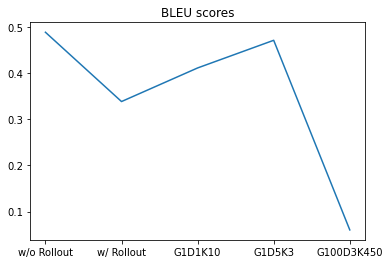

In [39]:
plt.title("BLEU scores")
plt.plot(["w/o Rollout","w/ Rollout","G1D1K10","G1D5K3","G100D3K450"],[b[0] for b in bleu_scores])

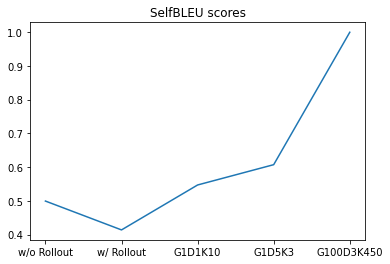

In [40]:
plt.title("SelfBLEU scores")
plt.plot(["w/o Rollout","w/ Rollout","G1D1K10","G1D5K3","G100D3K450"],[b[1] for b in bleu_scores])